# Training analysis for DeepRacer

This notebook has been built based on the `DeepRacer Log Analysis.ipynb` provided by the AWS DeepRacer Team. It has been reorganised and expanded to provide new views on the training data without the helper code which was moved into utility `.py` files.

## Usage


I have expanded this notebook from to present how I'm using this information. It contains descriptions that you may find not that needed once read. Since this file can change in the future, I recommend that you make its copy and reorganize it to your liking. This way you will not lose your changes and you'll be able to add things as you please.

## Contributions

As usual, your ideas are very welcome and encouraged so if you have any suggestions either bring them to [the AWS DeepRacer Community](http://join.deepracing.io) or share as code contributions.

## Training environments

Depending on whether you're running your training through the console or using the local setup, and on which setup for local training you're using, your experience will vary. As much as I would like everything to be taylored to your configuration, there may be some problems that you may face. If so, please get in touch through [the AWS DeepRacer Community](http://join.deepracing.io).

## Requirements

Before you start using the notebook, you will need to install some dependencies. If you haven't yet done so, have a look at [The README.md file](/edit/README.md#running-the-notebooks) to find what you need to install.

Apart from the install, you also have to configure your programmatic access to AWS. Have a look at the guides below, AWS resources will lead you by the hand:

AWS CLI: https://docs.aws.amazon.com/cli/latest/userguide/cli-chap-configure.html

Boto Configuration: https://boto3.amazonaws.com/v1/documentation/api/latest/guide/configuration.html

## Credits

I would like to thank [the AWS DeepRacer Community](http://join.deepracing.io) for all the feedback about the notebooks. If you'd like, follow [my blog](https://codelikeamother.uk) where I tend to write about my experiences with AWS DeepRacer.

# Log Analysis

Let's get to it.

## Imports

Run the imports block below:

In [ ]:
# When running in SageMaker Notebooks
#!conda install -n python3 -c conda-forge -y shapely

# When running in local docker
!conda install -c conda-forge -y shapely pandas matplotlib scikit-learn boto3

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

#Shapely Library
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString

import track_utils as tu
import log_analysis as la
import cw_utils as cw

# Make sure your boto version is >= '1.9.133'
cw.boto3.__version__

'1.10.8'

This block below has been prepared in case you would like to make some changes to the utility code that comes with this notebook. It will reload track_utlis.py, log_analysis.py and cw_utils.py without the need to reload the notebook. In normal usage of the notebook you will not need it.

In [51]:
# reload log_analysis and the rest of stuff here if needed
# (handy for code updates in utils, doesn't break anything if no changes)
import importlib
importlib.reload(la)
importlib.reload(cw)
importlib.reload(tu)

<module 'track_utils' from '/home/jovyan/work/log-analysis/track_utils.py'>

## Setting Region
This operation is not requried when running in a SageMaker notebook, running in your AWS environment.
However, when running locally, set your default region to where you are running your Deep Racer simulations

In [3]:
import os
os.environ["AWS_DEFAULT_REGION"] = "us-east-1"

## Load waypoints for the track you want to run analysis on

The track waypoint files usually show up as new races start. Be sure to check for them in repository updates. You only need to load them in the block below.

These files represent the coordinates of characteristic points of the track - the center line, inside border and outside border. Their main purpose is to visualise the track in images below. One thing that you may want to remember is that at the moment not all functions below work with all values of the coordinates. Especially some look awkward with bigger tracks or with negative coordinates. Usually there is an explanation on what to do to fix the view.

The naming of the tracks is not super consistent. I'm also not sure all of them are available in the console or locally. You may want to know that:
* London_Loop and Virtual_May19_Train_track - are the AWS DeepRacer Virtual League London Loop tracks
* Tokyo - is the AWS DeepRacer Virtual League Kumo Torakku track
* New_York - are the AWS DeepRacer Virtual League Empire City training and evaluation tracks
* China - are the AWS Deepracer Virtual League Shanghai Sudu training and evaluation tracks
* reinvent_base - is the re:Invent 2019 racing track

There are also other tracks that you may want to explore. Each of them has its own properties that you might find useful for your model.

Remeber that evaluation npy files are a community effort to visualise the tracks in the trainings, they aren't 100% accurate.

Tracks Available:

In [4]:
!ls tracks/
!ls logs/

AWS_track.npy	      London_Loop_Train.npy    Straight_track.npy
Bowtie_track.npy      New_York_Eval_Track.npy  Tokyo_Training_track.npy
China_eval_track.npy  New_York_Track.npy       Virtual_May19_Train_track.npy
China_track.npy       Oval_track.npy
H_track.npy	      reinvent_base.npy
deepracer-eval-sim-sample.log  deepracer-sim-xdt24ff0mljq.log
deepracer-sim-sample.log       deepracer-sim-y79jjcvqq73q.log


Take the name from results above and paste below to load the key elements of the track and view the outline of it.

Loaded 71 waypoints


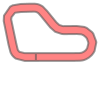

In [5]:
l_center_line, l_inner_border, l_outer_border, road_poly = tu.load_track("reinvent_base")

road_poly

## Get the logs

Depending on which way you are training your model, you will need a different way to load the data.

**AWS DeepRacer Console**
The logs are being stored in CloudWatch, in group `/aws/robomaker/SimulationJobs`. You will be using boto3 to download them based on the training ID (stream name prefix). If you wish to bulk export the logs from Amazon Cloudwatch to Amazon S3 :: https://docs.aws.amazon.com/AmazonCloudWatch/latest/logs/S3ExportTasks.html

**DeepRacer for Dummies/ARCC local training**
Those two setups come with a container that runs Jupyter Notebook (as you noticed if you're using one of them and reading this text). Logs are stored in `/logs/` and you just need to point at the latest file to see the current training. The logs are split for long running training if they exceed 500 MB. The log loading method has been extended to support that.

**Chris Rhodes' repo**
Chris repo doesn't come with logs storage out of the box. I would normally run `docker logs dr > /path/to/logfile` and then load the file.

Below I have prepared a section for each case. In each case you can analyse the logs as the training is being run, just in case of the Console you may need to force downloading of the logs as the `cw.download_log` method has a protection against needless downloads.

Select your preferred way to get the logs below and you can get rid of the rest.

In [6]:
# List the simulation ids availables
import boto3;
region='us-east-1'
sagemaker = boto3.client('sagemaker', region_name=region)

training_jobs = sagemaker.list_training_jobs()

def getName(data):
    return data['TrainingJobName']


result = map(getName,training_jobs['TrainingJobSummaries'])
list(result)

# training_jobs

Enter MFA code for arn:aws:iam::613576916451:mfa/tim.myerscough: ········


['dr-sm-rltj--20191025094433-a787aa3a-2b1e-48fd-bb8a-13b18c0a75e4',
 'dr-sm-rltj--20191007041906-a6c1ed02-aff6-438d-9e80-4cfb53424d6c',
 'dr-sm-rltj--20190828055846-9396b98b-29ce-44fb-ab9f-187786d3a0ec',
 'dr-sm-rltj--20190828054735-bf35aec3-9cfa-4830-b6d5-591bc7dd2181',
 'dr-sm-rltj--20190828005118-fac04506-f692-46ed-8486-b6b04ee3de7e',
 'dr-sm-rltj--20190827133422-042beba9-b6b0-448d-a759-5e3d736ef3ab',
 'dr-sm-rltj--20190827040203-4ce3d14d-88ac-4e33-b90f-c2af65d89cf9',
 'dr-sm-rltj--20190826021109-2ea02457-dfb8-49a4-95d3-403ab0b211ba',
 'dr-sm-rltj--20190825051206-18993100-5e62-4a02-b558-7b370f6ffd23',
 'rl-deepracersagemaker-19-07-30--06-24']

In [7]:
robomaker = boto3.client('robomaker')

simulation_jobs = robomaker.list_simulation_jobs()

def get_arn(data):
    return data['arn']

def get_id(data):
    arn = get_arn(data)
    name = arn.split('/')[1]
    return name
    
result = map(get_id,simulation_jobs['simulationJobSummaries'])

# TODO - map the simulation job name to the version of the DeepRacer
# https://console.aws.amazon.com/deepracer/api/awssilverstonecloudservice
# Undocumented API...
list(result)



['sim-5tdcqc26yx0b',
 'sim-xdt24ff0mljq',
 'sim-gcgd2sn59pmt',
 'sim-3cf46kj5d82l',
 'sim-m4l5l9crpflc',
 'sim-wz2d032j57vh',
 'sim-6plr3b6dzyds',
 'sim-21615y9dj3nm',
 'sim-y3875v5z8yld',
 'sim-sz52dq8rfngv',
 'sim-4fsxrdt60418',
 'sim-86f8p7h3d5y5',
 'sim-343d3g8r2h68',
 'sim-y79jjcvqq73q',
 'sim-2sxt38649w2n',
 'sim-pmzv51hm3l1d',
 'sim-619wrfr9sxzq',
 'sim-zf22y1n10bk5',
 'sim-q5ndj9xbljpg',
 'sim-sfhy4mny9l9w']

In [9]:
# AWS DeepRacer Console

# reward-progress-v4 - reinvent
REWARD_PROGRESS_V4 = 'sim-y79jjcvqq73q'

stream_name = REWARD_PROGRESS_V4 ## CHANGE This to your simulation application ID
fname = 'logs/deepracer-%s.log' %stream_name  # The log will be downloaded into the specified path
cw.download_log(fname, stream_prefix=stream_name)  # add force=True if you downloaded the file before but want to repeat


# DeepRacer for Dummies / ARCC repository - comment the above and uncomment
# the lines below. They rely on a magic command to list log files
# ordered by time and pick up the most recent one (index zero).
# If you want an earlier file, change 0 to larger value.
# !ls -t /logs/*.log
# fname = !ls -t /logs/*.log
# fname = fname[0]


# Chris Rhodes' repository
# Use a preferred way of saving the logs to a file , then set an fname value to load it
# fname = /path/to/your/log/file

In [10]:
!ls logs/

deepracer-eval-sim-sample.log  deepracer-sim-xdt24ff0mljq.log
deepracer-sim-sample.log       deepracer-sim-y79jjcvqq73q.log


## Load the trace training log

Now that the data is downloaded, we need to load it into memory. We will first read it from file and then convert to data frames in Pandas. [Pandas](https://pandas.pydata.org/) is a Python library for handling and analysing large amounts of data series. Remember this name, you may want to learn more about how to use it to get more information that you would like to get from the logs. Examples below are hardly scratching the surface.

One important information to enter is the setting of your Episodes per iteration hyperparameter. This is used to group the episodes.

In [11]:
# TODO - pull this from the metadata.
EPISODES_PER_ITERATION = 20 #  Set to value of your hyperparameter in training
fname = 'logs/deepracer-%s.log' %stream_name
data = la.load_data(fname)
df = la.convert_to_pandas(data, episodes_per_iteration=EPISODES_PER_ITERATION)

df = df.sort_values(['episode', 'steps'])
print(df)
# personally I think normalizing can mask too high rewards so I am commenting it out,
# but you might want it.
# la.normalize_rewards(df)

       iteration  episode  steps       x       y     yaw  steer  throttle  \
0              1        0      0  305.00   68.32  0.0004   0.00      0.00   
1              1        0      1  305.00   68.32  0.0003   0.00      1.67   
2              1        0      2  305.03   68.30 -0.0018  -0.26      1.67   
3              1        0      3  305.26   68.36  0.0019  -0.26      5.00   
4              1        0      4  305.63   68.26 -0.0053   0.52      3.33   
...          ...      ...    ...     ...     ...     ...    ...       ...   
88455         29      573    243  624.57  260.85  2.8663   0.26      3.33   
88456         29      573    244  619.81  261.48  2.9088   0.26      1.67   
88457         29      573    245  615.88  261.80  2.9458   0.26      1.67   
88458         29      573    246  612.40  261.95  2.9780   0.26      1.67   
88459         29      573    247  608.64  261.89  3.0162   0.52      3.33   

       action   reward  done on_track  progress  closest_waypoint  track_le

Note the first line below: it takes a reward class from log-analysis/rewards, imports, instantiates and recalculates for the log. This lets you do some testing before you start training and rule out some obvious things.

Just remember: not all params are provided, you are free to implement them and raise a Pull Request for log_analysis.df_to_params method.

Wrap your reward function like in the sample one below.

Final warning: there is a loss of precision in the logs and also potentially potential bugs. If you find any, please fix, please report.

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


new reward not found, using reward as its values
Number of episodes =  573
Number of iterations =  29


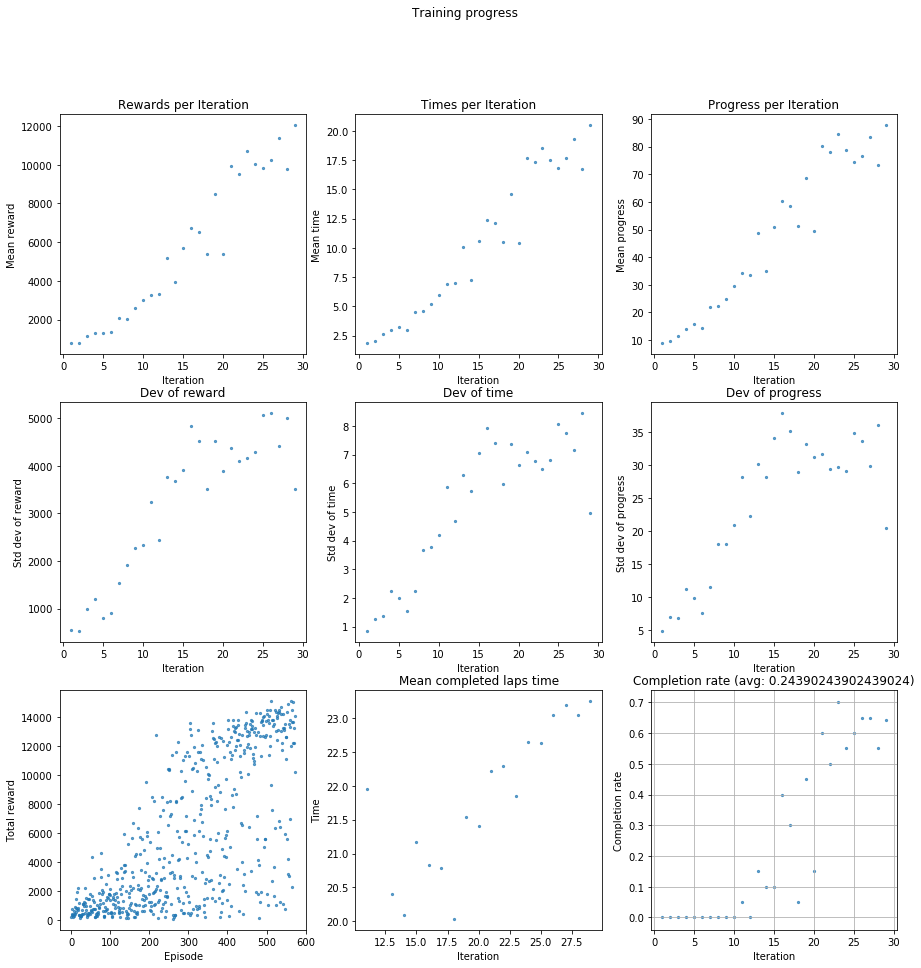

<Figure size 432x288 with 0 Axes>

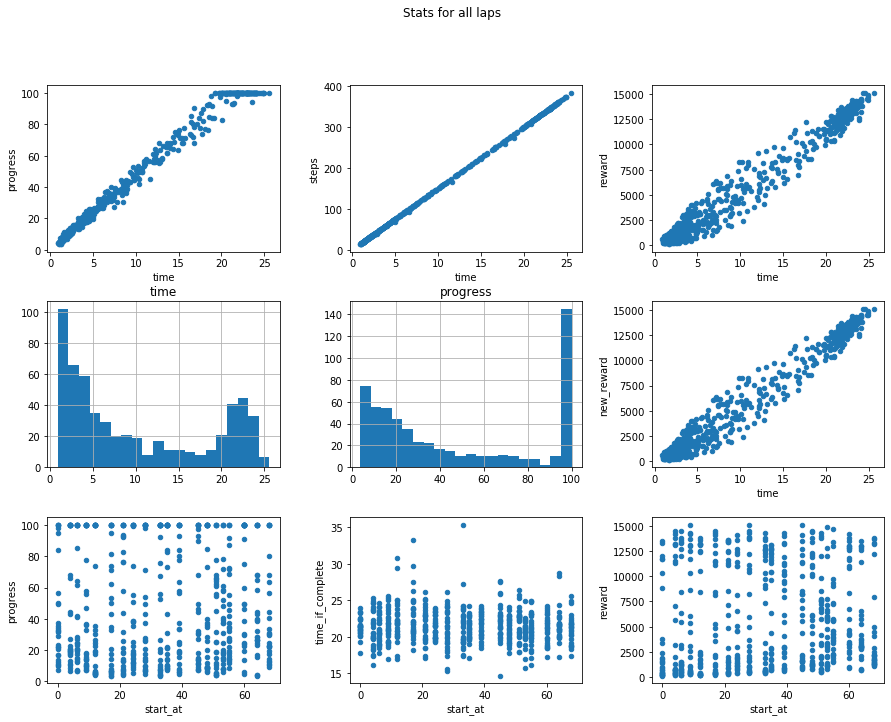

<Figure size 432x288 with 0 Axes>

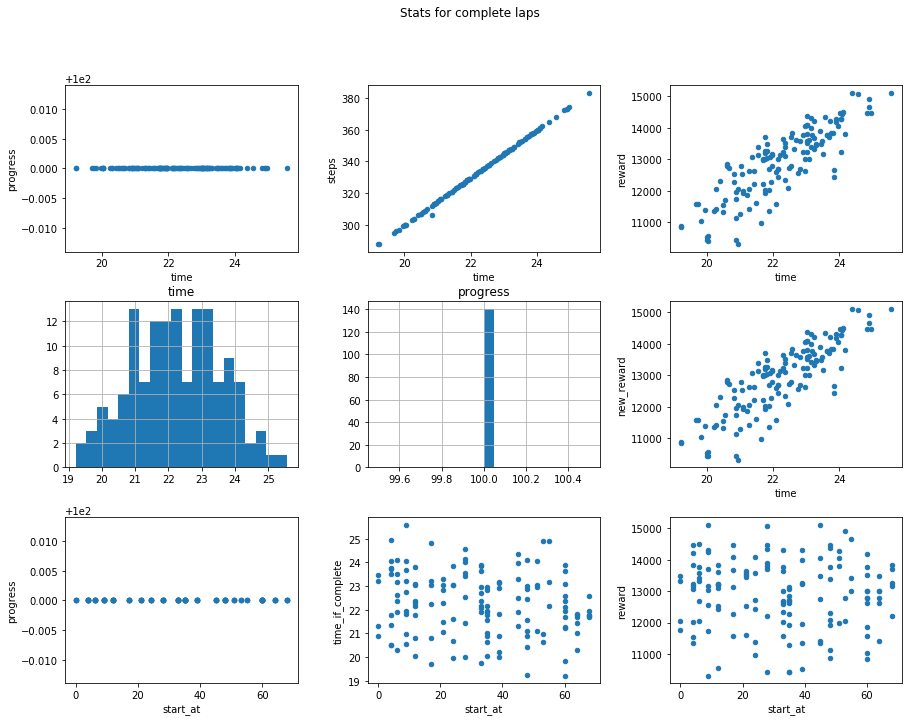

<Figure size 432x288 with 0 Axes>

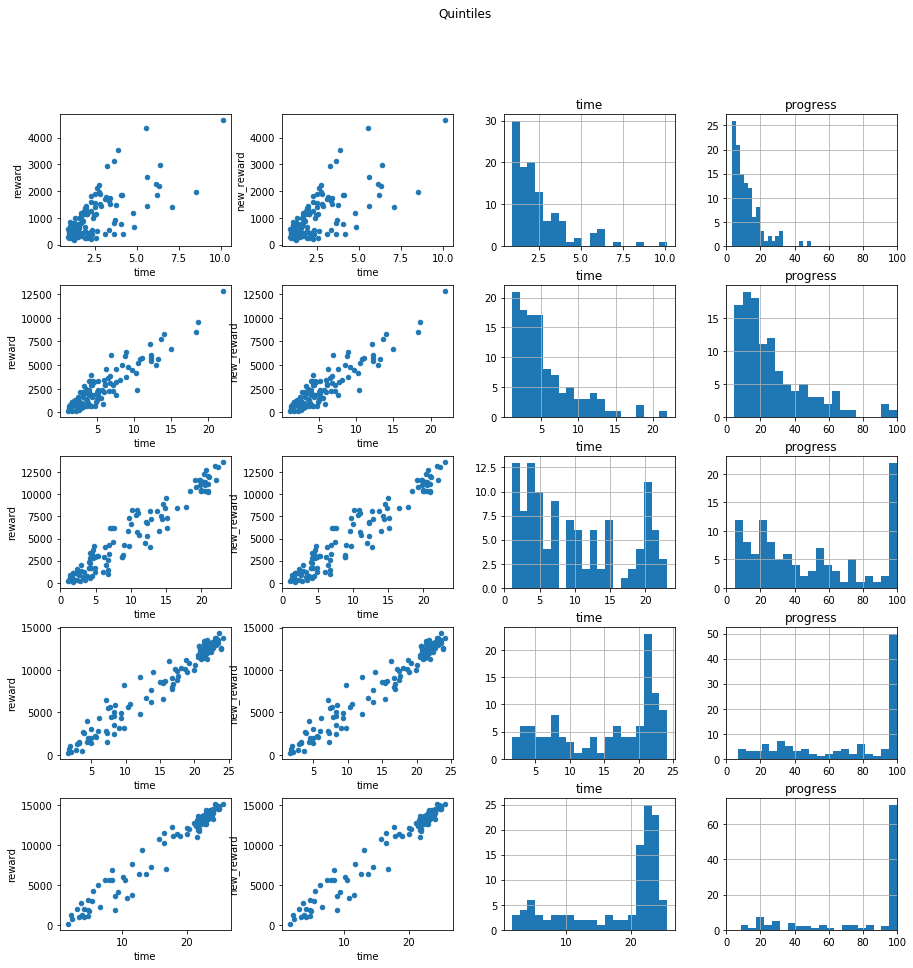

<Figure size 432x288 with 0 Axes>

In [12]:
#Uncomment the line of code below to evaluate a different reward function
#la.new_reward(df, l_center_line, 'reward.reward_sample') #, verbose=True)

simulation_agg = la.simulation_agg(df)

la.analyze_training_progress(simulation_agg, title='Training progress')

# This gives the warning about ptp method deprecation. The code looks as if np.ptp was used, I don't know how to fix it.
la.scatter_aggregates(simulation_agg, 'Stats for all laps')

complete_ones = simulation_agg[simulation_agg['progress']==100]

if complete_ones.shape[0] > 0:
    la.scatter_aggregates(complete_ones, 'Stats for complete laps')

la.analyze_categories(simulation_agg, title='Quintiles')

In [13]:
print (len(complete_ones))

140


The calls below are useful when you want to look at some values largest or smallest. You can then take the episode number and scatter it below.

In [14]:
# this is useful if you struggle to get a complete lap
simulation_agg.nlargest(10, 'new_reward')

,iteration,episode,steps,start_at,progress,time,new_reward,throttle,reward,time_if_complete,reward_if_complete,quintile,complete
512,26,512,365,45,100.0,24.370344,15111.2993,2.533087,15111.2993,24.370344,15111.2993,5th,1
563,29,563,383,9,100.0,25.571822,15102.4672,2.462214,15102.4672,25.571822,15102.4672,5th,1
568,29,568,368,28,100.0,24.561267,15067.7697,2.548699,15067.7697,24.561267,15067.7697,5th,1
555,28,555,373,53,100.0,24.895978,14912.5262,2.594652,14912.5262,24.895978,14912.5262,5th,1
536,27,536,373,55,100.0,24.899078,14666.1704,2.541230,14666.1704,24.899077,14666.1704,5th,1
502,26,502,361,6,100.0,24.098918,14489.9371,2.644088,14489.9371,24.098918,14489.9371,5th,1
565,29,565,372,17,100.0,24.827124,14479.4528,2.565952,14479.4528,24.827124,14479.4528,5th,1
508,26,508,360,28,100.0,24.033957,14469.4956,2.618920,14469.4956,24.033957,14469.4956,5th,1
521,27,521,374,4,100.0,24.962382,14460.2315,2.552107,14460.2315,24.962382,14460.2315,5th,1
533,27,533,361,48,100.0,24.088328,14454.2466,2.505691,14454.2466,24.088328,14454.2466,5th,1


In [15]:
# fastest complete laps
complete_ones.nsmallest(5, 'time')

,iteration,episode,steps,start_at,progress,time,new_reward,throttle,reward,time_if_complete,reward_if_complete,quintile,complete
317,16,317,288,60,100.0,19.220161,10836.1660,3.097163,10836.1660,19.220161,10836.1660,3rd,1
373,19,373,288,48,100.0,19.228734,10875.1439,3.108616,10875.1439,19.228734,10875.1439,4th,1
325,17,325,295,17,100.0,19.687609,11567.5766,3.029966,11567.5766,19.687609,11567.5766,3rd,1
269,14,269,296,33,100.0,19.753497,11579.1119,3.086599,11579.1119,19.753497,11579.1119,3rd,1
337,17,337,297,60,100.0,19.829729,11039.9652,3.171611,11039.9652,19.829729,11039.9652,3rd,1


In [17]:
# best rewards in completed laps
complete_ones.nlargest(5, 'reward')

,iteration,episode,steps,start_at,progress,time,new_reward,throttle,reward,time_if_complete,reward_if_complete,quintile,complete
512,26,512,365,45,100.0,24.370344,15111.2993,2.533087,15111.2993,24.370344,15111.2993,5th,1
563,29,563,383,9,100.0,25.571822,15102.4672,2.462214,15102.4672,25.571822,15102.4672,5th,1
568,29,568,368,28,100.0,24.561267,15067.7697,2.548699,15067.7697,24.561267,15067.7697,5th,1
555,28,555,373,53,100.0,24.895978,14912.5262,2.594652,14912.5262,24.895978,14912.5262,5th,1
536,27,536,373,55,100.0,24.899078,14666.1704,2.541230,14666.1704,24.899077,14666.1704,5th,1


In [28]:
fastest_episodes = complete_ones.nlargest(5, 'reward')['episode']
list(fastest_episodes)

[512, 563, 568, 555, 536]

In [18]:
# best rewards in completed laps
complete_ones.nlargest(5, 'new_reward')

,iteration,episode,steps,start_at,progress,time,new_reward,throttle,reward,time_if_complete,reward_if_complete,quintile,complete
512,26,512,365,45,100.0,24.370344,15111.2993,2.533087,15111.2993,24.370344,15111.2993,5th,1
563,29,563,383,9,100.0,25.571822,15102.4672,2.462214,15102.4672,25.571822,15102.4672,5th,1
568,29,568,368,28,100.0,24.561267,15067.7697,2.548699,15067.7697,24.561267,15067.7697,5th,1
555,28,555,373,53,100.0,24.895978,14912.5262,2.594652,14912.5262,24.895978,14912.5262,5th,1
536,27,536,373,55,100.0,24.899078,14666.1704,2.541230,14666.1704,24.899077,14666.1704,5th,1


In [19]:
# this is useful if you struggle to get a complete lap
simulation_agg.nlargest(5, 'progress')

,iteration,episode,steps,start_at,progress,time,new_reward,throttle,reward,time_if_complete,reward_if_complete,quintile,complete
217,11,217,329,60,100.0,21.957062,12784.4479,2.889576,12784.4479,21.957062,12784.4479,2nd,1
248,13,248,300,28,100.0,20.021348,10422.6416,2.996179,10422.6416,20.021348,10422.6416,3rd,1
250,13,250,313,35,100.0,20.891178,10420.3587,3.047389,10420.3587,20.891178,10420.3587,3rd,1
258,13,258,304,64,100.0,20.291328,11419.5514,3.076820,11419.5514,20.291328,11419.5514,3rd,1
269,14,269,296,33,100.0,19.753497,11579.1119,3.086599,11579.1119,19.753497,11579.1119,3rd,1


In [20]:
# list all entries aggregated per episode. Handy for comparing the outcomes for reward and new_reward,
# but for not much else.
simulation_agg.head()

,iteration,episode,steps,start_at,progress,time,new_reward,throttle,reward,time_if_complete,reward_if_complete,quintile,complete
0,1,0,39,0,12.3944,2.607649,246.4073,3.292250,246.4073,21.038930,1988.053476,1st,0
1,1,1,61,4,20.6078,4.072081,769.5987,3.387097,769.5987,19.759900,3734.501985,1st,0
2,1,2,35,6,12.2787,2.334020,404.3940,3.472222,404.3940,19.008689,3293.459405,1st,0
3,1,3,31,9,9.8343,2.069284,431.8183,3.437187,431.8183,21.041499,4390.940891,1st,0
4,1,4,25,12,6.8575,1.669147,343.0109,3.077308,343.0109,24.340459,5001.981772,1st,0


In [21]:
pd.set_option('display.max_rows', 500)

# list all parsed log lines. Handy for comparing the outcomes for reward and new_reward,
# but for not much else.
df[df['episode']==10]

,iteration,episode,steps,x,y,yaw,steer,throttle,action,reward,done,on_track,progress,closest_waypoint,track_len,timestamp,new_reward
288,1,10,0,407.27,339.49,2.2547,0.00,0.00,0.0,44.9277,0,True,0.7928,35,17.67,1566913085.2480676,44.9277
289,1,10,1,406.97,339.79,2.2579,0.52,1.67,12.0,45.1683,0,True,0.8168,35,17.67,1566913085.3166275,45.1683
290,1,10,2,405.78,340.95,2.2714,-0.26,5.00,5.0,41.5508,0,True,0.9102,35,17.67,1566913085.384828,41.5508
291,1,10,3,403.82,342.88,2.2894,0.26,1.67,9.0,40.5500,0,True,1.0650,36,17.67,1566913085.4500008,40.5500
292,1,10,4,401.00,345.59,2.3102,-0.52,5.00,2.0,40.2111,0,True,1.2845,36,17.67,1566913085.5182354,40.2111
293,1,10,5,397.67,349.11,2.3167,-0.52,5.00,2.0,41.1157,0,True,1.5579,36,17.67,1566913085.5824883,41.1157
294,1,10,6,393.14,354.14,2.3114,0.00,5.00,8.0,41.2349,0,True,1.9409,36,17.67,1566913085.651522,41.2349
295,1,10,7,388.60,359.43,2.3055,-0.52,1.67,0.0,41.3362,0,True,2.3353,36,17.67,1566913085.7160223,41.3362
296,1,10,8,384.93,364.08,2.2800,-0.26,1.67,3.0,41.3375,0,True,2.6700,37,17.67,1566913085.782074,41.3375
297,1,10,9,381.99,367.92,2.2611,0.00,1.67,6.0,41.2707,0,True,2.9436,37,17.67,1566913085.851165,41.2707


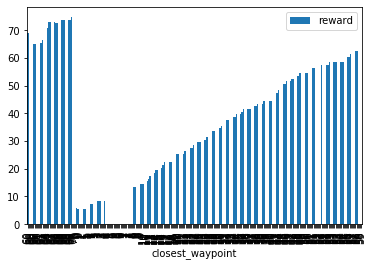

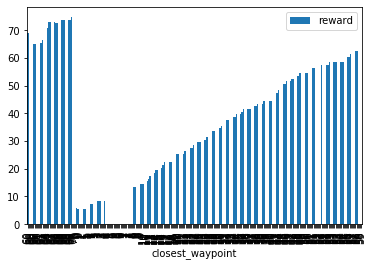

In [25]:
#This shows a histogram of actions per waypoint. Will let you spot potentially problematic places
# Compare a fast lap
episode = df[df['episode']==317]
episode[:-1].plot.bar(x='closest_waypoint', y='reward')

# Compare with a high reward 
reward_episode = df[df['episode']==512]
episode[:-1].plot.bar(x='closest_waypoint', y='reward')

## Analyze the reward distribution for your reward function

### Path taken for top reward iterations

NOTE: in a single episode, the car can go around multiple laps, the episode is terminated when car completes 1000 steps

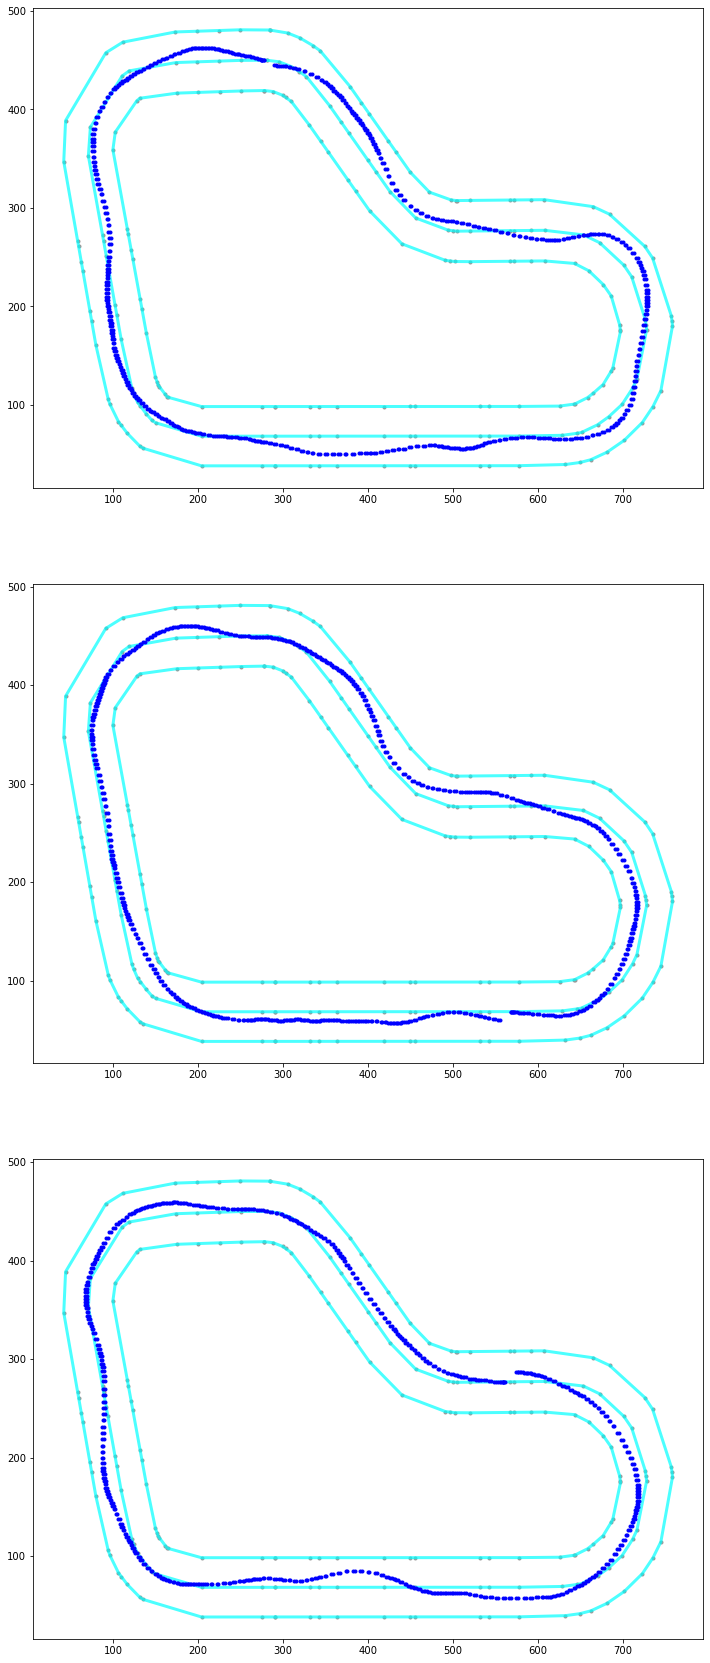

<Figure size 432x288 with 0 Axes>

In [26]:
action_map, episode_map, sorted_idx = la.episode_parser(data)    
fig = la.plot_top_laps(sorted_idx[:],  episode_map, l_center_line, l_inner_border, l_outer_border, 3)

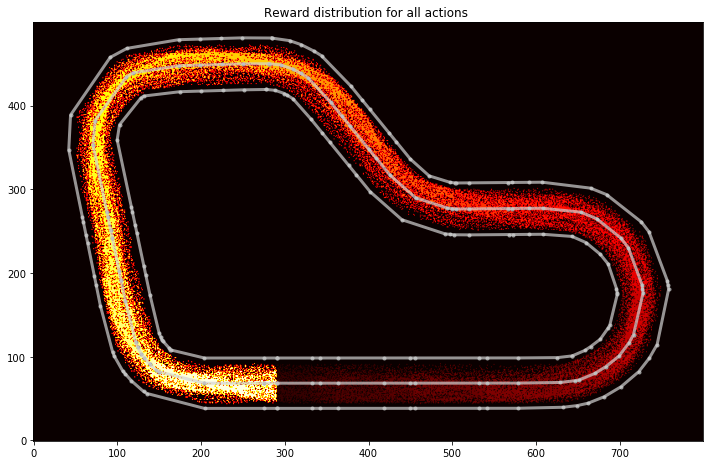

In [32]:
# because Kumo Torakku has negative y values, I shamelessly took
# RichardFan's modificationg for plot_track and refactored it to offer an x_shift and y_shift
# They may not apply to other tracks. You will need to change it in the future. Simply add parameters:
# track_size=(700,1000), y_shift=300
track = la.plot_track(df, l_center_line, l_inner_border, l_outer_border)

plt.title("Reward distribution for all actions ")
im = plt.imshow(track, cmap='hot', interpolation='bilinear', origin="lower") 

### Plot a particular iteration


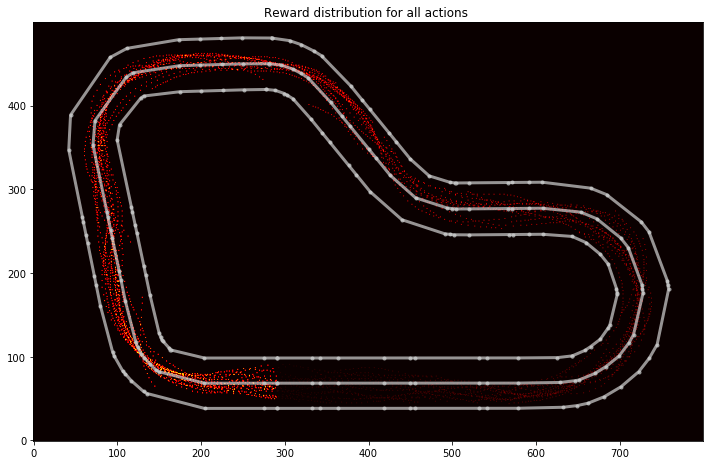

In [34]:
iteration_id = 26
track = la.plot_track(df[df['iteration'] == iteration_id], l_center_line, l_inner_border, l_outer_border)
plt.title("Reward distribution for all actions ")
im = plt.imshow(track, cmap='hot', interpolation='bilinear', origin="lower") 

### Path taken in a particular episode

In [35]:
## Evaluation RUN
def plot_episode_run(df, E, center_line, inner_border, outer_border):
    fig = plt.figure(1, figsize=(12, 16))
    ax = fig.add_subplot(211)
    la.print_border(ax, center_line, inner_border, outer_border) 
    episode_data = df[df['episode'] == E]
    for row in episode_data.iterrows():
        x1,y1,action,reward = row[1]['x'], row[1]['y'], row[1]['action'], row[1]['reward']
        car_x2, car_y2 = x1 - 0.02, y1
        plt.plot([x1, car_x2], [y1, car_y2], 'r.')

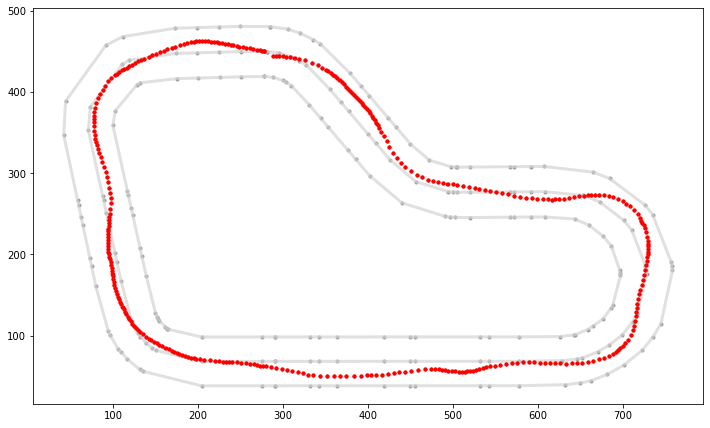

In [37]:
plot_episode_run(df, 512, l_center_line, l_inner_border, l_outer_border) # arbitrary episode

### Path taken in a particular Iteration

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


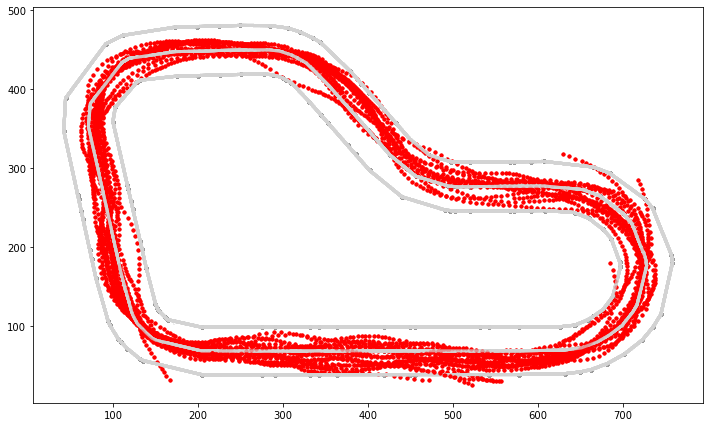

In [39]:
iteration_id = 26
# EPISODE_PER_ITER = 20 # TODO this can be fetched from training logs

for i in range((iteration_id-1)*EPISODE_PER_ITER, (iteration_id)*EPISODE_PER_ITER):
    plot_episode_run(df, i, l_center_line, l_inner_border, l_outer_border)

# Bulk training load

This is some slow and heavy stuff in here. You can download all logs (or part of them if you play with `not_older_than` and `older_than` parameters that take a string representation of a date in ISO format, for instance `DD-MM-YYYY` works).

Since it can be a lot of downloading, it is commented out in here.

Files downloaded once will not be downloaded again unless you add `force=True`.

In [ ]:
#logs = cw.download_all_logs('logs/SELECT_YOUR_SUBFOLDER/training/deepracer-', '/aws/robomaker/SimulationJobs')

Load every log from a folder. Every single one. This is a lot of data. If you want to save yourself some time later, below you have code to save and load all that with use of pickle.

In [ ]:
import os

base_folder = 'logs/SELECT_YOUR_SUBFOLDER/training'
df_list = list()
big_training_panda = None
for stream in os.listdir(base_folder):
    data = la.load_data('%s/%s' % (base_folder, stream))
    df = la.convert_to_pandas(data)
    df['stream'] = stream[10:]
    if big_training_panda is not None:
        big_training_panda = big_training_panda.append(df)
    else:
        big_training_panda = df


In [ ]:
# Have I mentioned a lot of data? This stores the data preprocessed for time savings
big_training_panda.to_pickle('bulk_training_set.pickle')

In [ ]:
from pandas import read_pickle

big_training_panda = read_pickle('bulk_training_set.pickle')

In [ ]:
# as usual, handle with care. Towards the end of the London Loop I needed 30-45 minutes to recalculate the reward.
#la.new_reward(big_training_panda, l_center_line, 'reward.reward_sample')

In [ ]:
big_simulation_agg = la.simulation_agg(big_training_panda, 'stream')

big_complete_ones = big_simulation_agg[big_simulation_agg['progress']==100]

In [ ]:
grouped = big_simulation_agg.groupby(['stream'])

for name, group in grouped:
    la.scatter_aggregates(group, title=name)

By the end of London Loop I had so much noise and random tries that wanted to find the most promising version of my model to submit. I used the below piece of code to iterate through all the stream values to detect the one with most promising times histogram. I should've added progress as well since the fastest ones hardly ever completed a lap. I will leave adding that as an exercise for the reader.

In [ ]:
values = []
show = []
show_above = -1
i = 0
for value in big_complete_ones.stream.values:
    if value in values:
        continue
    values.append(value)
    if i in show or i > show_above:
        print(value)
        big_complete_ones[big_complete_ones['stream']==value].hist(column=['time'], bins=20)
    i += 1

In [ ]:
# display loads of everything
big_simulation_agg

# Action breakdown per iteration and historgram for action distribution for each of the turns - reinvent track

This plot is useful to understand the actions that the model takes for any given iteration. 

This is a bit of an attempt to abstract away from the brilliant function in the original notebook towards a more general graph that we could use. It should be treated as a work in progress. The track_breakdown could be used as a starting point for a general track information object to handle all the customisations needed in methods of this notebook.

A breakdown track data needs to be available for it. If you cannot find it for the desired track, MAKEIT.

Currently supported tracks:

In [40]:
la.track_breakdown.keys()

dict_keys(['reinvent2018', 'london_loop'])

The second parameter is either a single index or a list of indices for df iterations that you would like to view. You can for instance use `sorted_idx` list which is a sorted list of iterations from the highest to lowest reward.

Bear in mind that you will have to provide a proper action naming in parameter `action_names`, this function assumes only six actions by default. I think they need to match numbering of actions in your model's metadata json file.

Number of steps in iteration= 3126


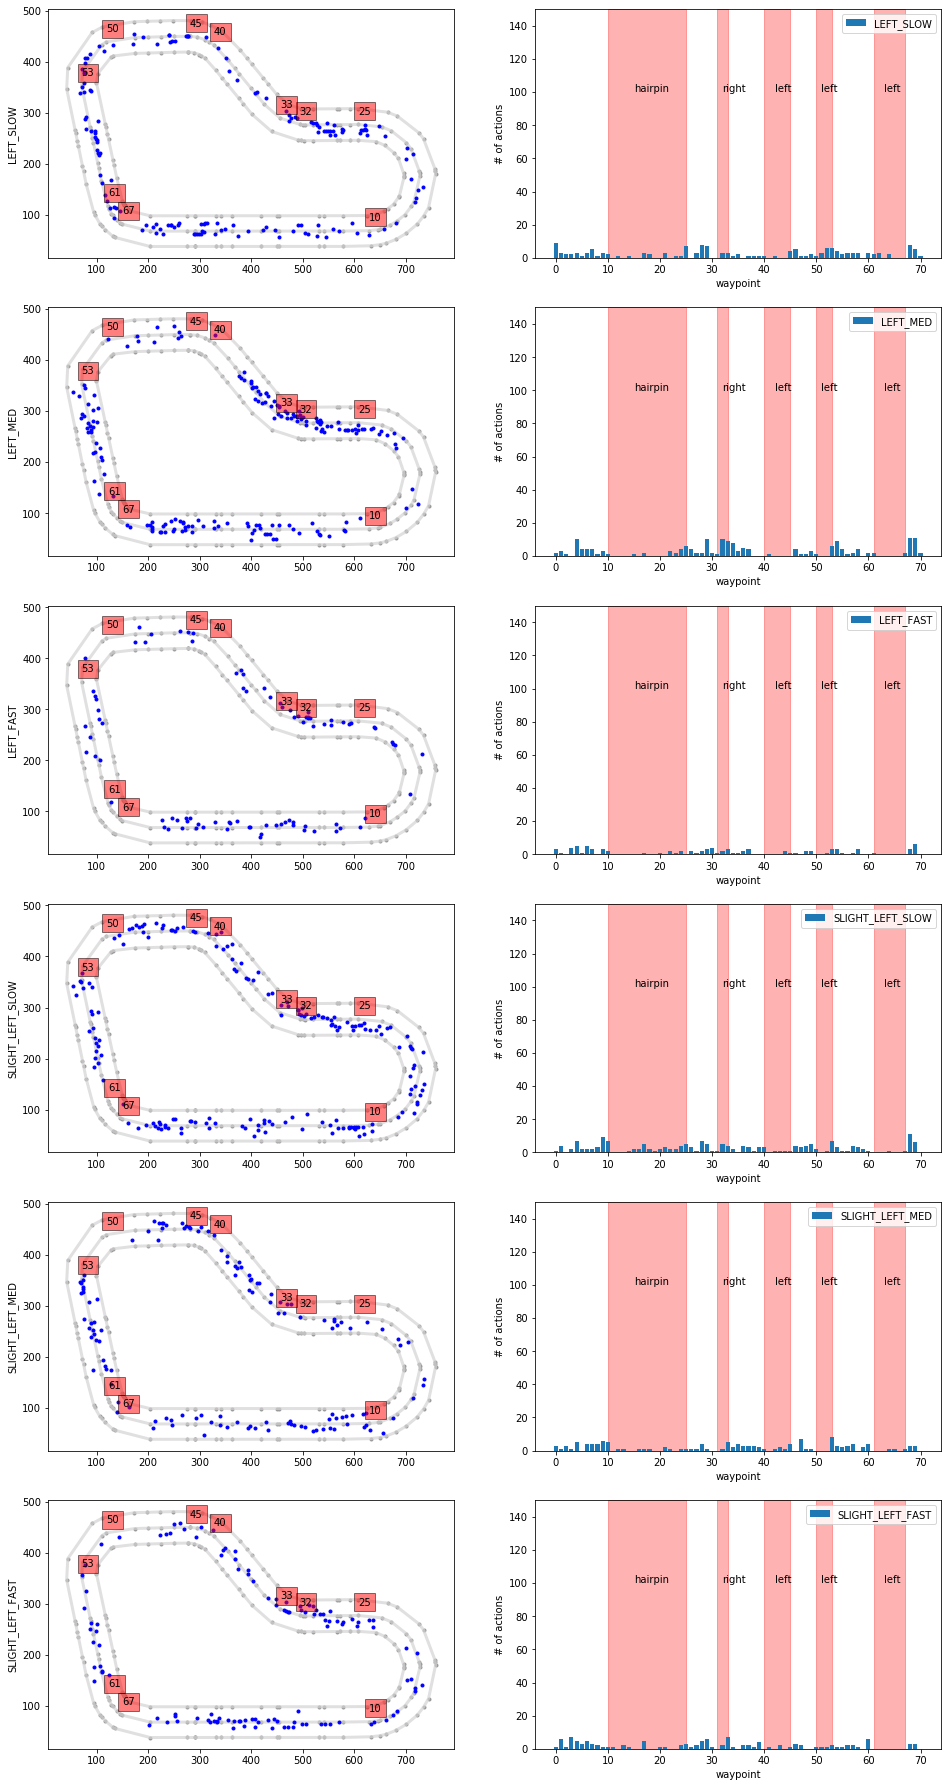

<Figure size 432x288 with 0 Axes>

In [49]:
# TODO - pull this from metadata?
# Available in log file: 'Loaded action space from file:'
# e.g. Loaded action space from file: [{'speed': 1.6666666666666665, 'index': 0, 'steering_angle': -30}, {'speed': 3.333333333333333, 'index': 1, 'steering_angle': -30}, ...]
action_names=[
    'LEFT_SLOW',
    'LEFT_MED',
    'LEFT_FAST',
    'SLIGHT_LEFT_SLOW',
    'SLIGHT_LEFT_MED',
    'SLIGHT_LEFT_FAST',
#     'STRAIGHT_SLOW',
#     'STRAIGHT_MED',
#     'STRAIGHT_FAST',
#     'SLIGHT_RIGHT_SLOW',
#     'SLIGHT_RIGHT_MED',
#     'SLIGHT_RIGHT_FAST',
#     'RIGHT_SLOW',
# #     'RIGHT_MED',
# #     'RIGHT_FAST'
]
# action_names=[
#     'LEFT',
#     'RIGHT',
#     'STRAIGHT',
#     'SLOW',
#     'MED',
#     'FAST'
# ]

# la.action_breakdown(df, 20, la.track_breakdown['reinvent2018'], l_center_line, l_inner_border, l_outer_border)
la.action_breakdown(df, 20, la.track_breakdown['reinvent2018'], l_center_line, l_inner_border, l_outer_border, action_names=action_names)

You only seem to be able to have a maximum of 6 labels on a plot.

If you have a larger action space, call the function multiple times with an offset

Number of steps in iteration= 3126


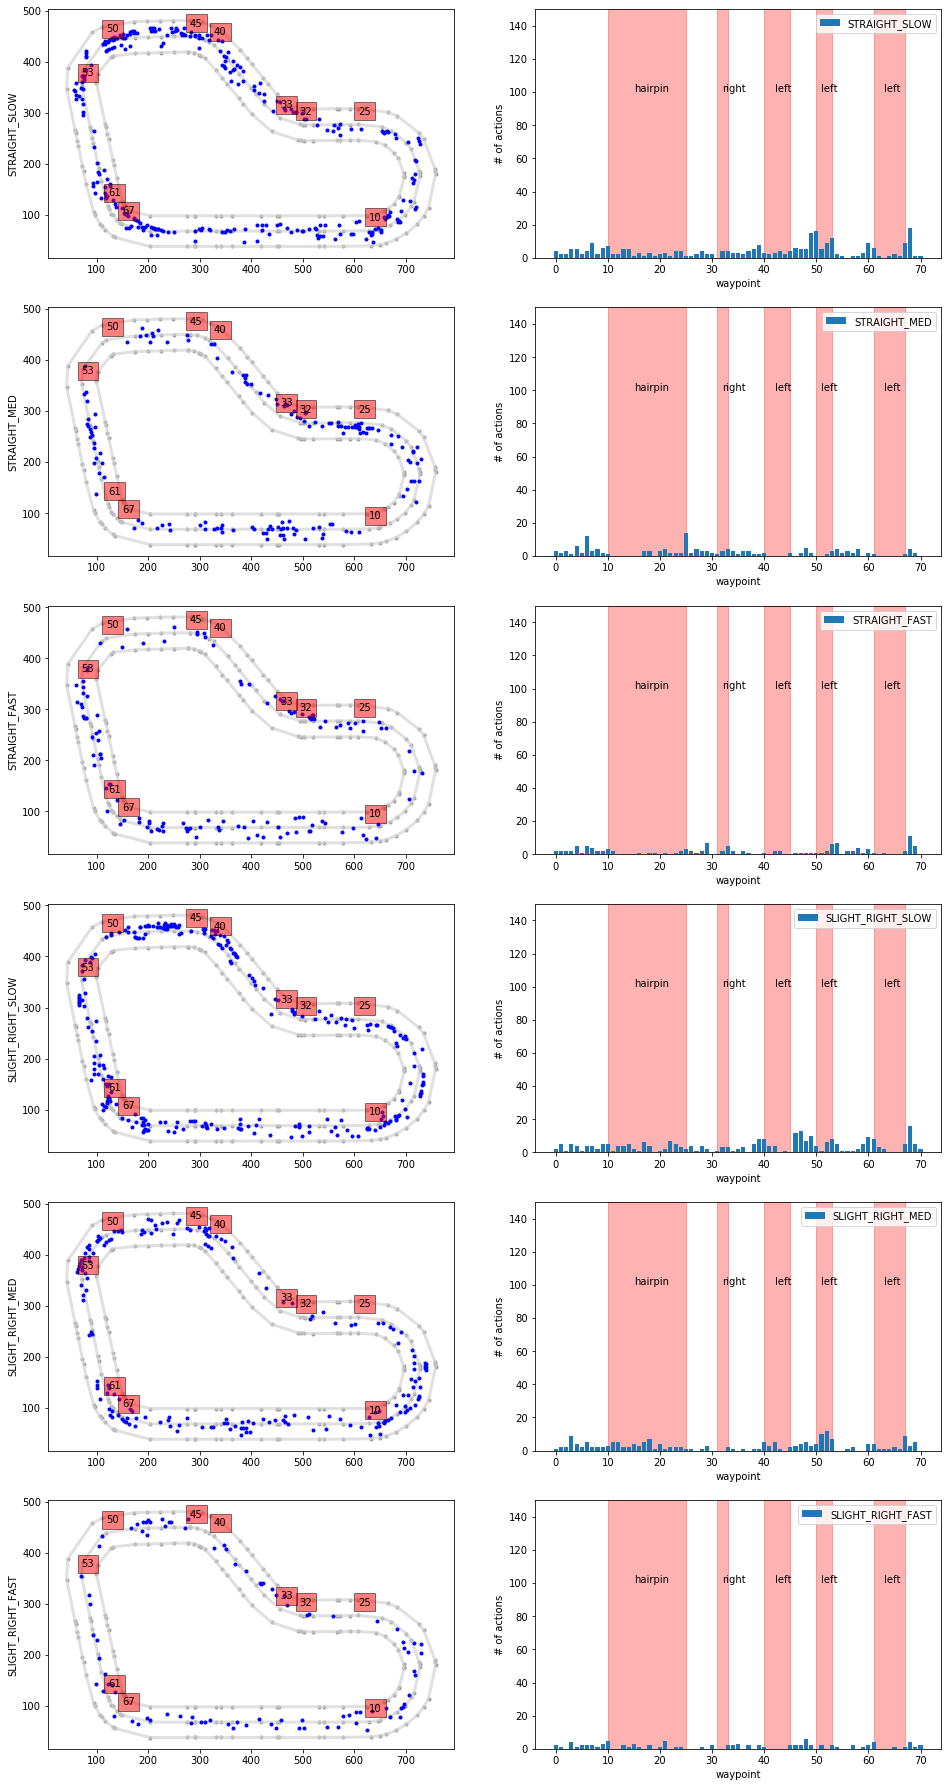

<Figure size 432x288 with 0 Axes>

In [52]:
offset = 6
action_names=[
#     'LEFT_SLOW',
#     'LEFT_MED',
#     'LEFT_FAST',
#     'SLIGHT_LEFT_SLOW',
#     'SLIGHT_LEFT_MED',
#     'SLIGHT_LEFT_FAST',
    'STRAIGHT_SLOW',
    'STRAIGHT_MED',
    'STRAIGHT_FAST',
    'SLIGHT_RIGHT_SLOW',
    'SLIGHT_RIGHT_MED',
    'SLIGHT_RIGHT_FAST',
#     'RIGHT_SLOW',
# #     'RIGHT_MED',
# #     'RIGHT_FAST'
]
la.action_breakdown(df, 20, la.track_breakdown['reinvent2018'], l_center_line, l_inner_border, l_outer_border, action_names=action_names, offset=offset)

Number of steps in iteration= 3126


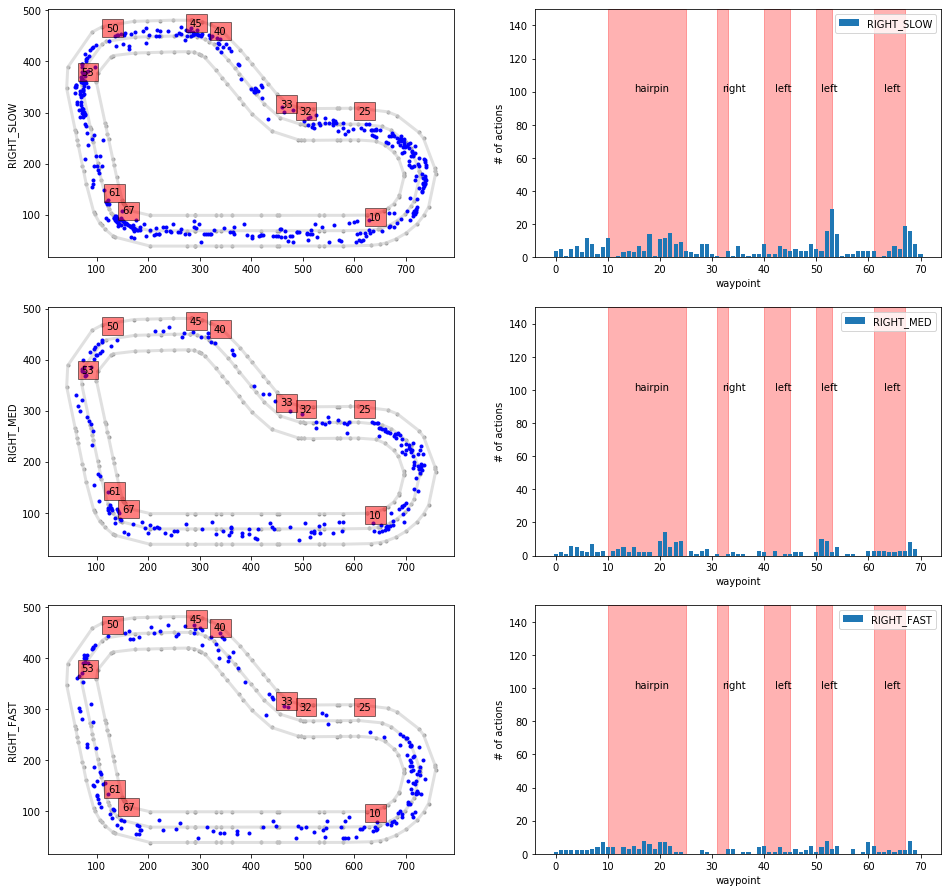

<Figure size 432x288 with 0 Axes>

In [53]:
offset = 12
action_names=[
#     'LEFT_SLOW',
#     'LEFT_MED',
#     'LEFT_FAST',
#     'SLIGHT_LEFT_SLOW',
#     'SLIGHT_LEFT_MED',
#     'SLIGHT_LEFT_FAST',
#     'STRAIGHT_SLOW',
#     'STRAIGHT_MED',
#     'STRAIGHT_FAST',
#     'SLIGHT_RIGHT_SLOW',
#     'SLIGHT_RIGHT_MED',
#     'SLIGHT_RIGHT_FAST',
    'RIGHT_SLOW',
    'RIGHT_MED',
    'RIGHT_FAST'
]
la.action_breakdown(df, 20, la.track_breakdown['reinvent2018'], l_center_line, l_inner_border, l_outer_border, action_names=action_names, offset=offset)